# 30) Higher Dimensions

## Last time

* Accuracy of piecewise constant (nearest neighbor) interpolation
* Piecewise polynomial methods
* Cubic Splines
* Interpolations.jl Library

## Today

1. Splines conditioning
2. Boundary Value Problems
3. Higher dimensions

In [1]:
using LinearAlgebra
using Plots
default(linewidth=4, legendfontsize=12)
using LaTeXStrings

function vander(x, k=nothing)
    if isnothing(k)
        k = length(x)
    end
    m = length(x)
    V = ones(m, k)
    for j in 2:k
        V[:, j] = V[:, j-1] .* x
    end
    V
end

function vander_chebyshev(x, n=nothing)
    if isnothing(n)
        n = length(x) # Square by default
    end
    m = length(x)
    T = ones(m, n)
    if n > 1
        T[:, 2] = x
    end
    for k in 3:n
        T[:, k] = 2 * x .* T[:,k-1] - T[:, k-2]
    end
    T
end

function interp_nearest(x, s)
    A = zeros(length(s), length(x))
    for (i, t) in enumerate(s)
        loc = nothing
        dist = Inf
        for (j, u) in enumerate(x)
            if abs(t - u) < dist
                loc = j
                dist = abs(t - u)
            end
        end
        A[i, loc] = 1
    end
    A
end

runge(x) = 1 / (1 + 10*x^2)

CosRange(a, b, n) = (a + b)/2 .+ (b - a)/2 * cos.(LinRange(-pi, 0, n))

vcond(mat, points, nmax) = [cond(mat(points(-1, 1, n))) for n in 2:nmax]


vcond (generic function with 1 method)

## Recap spline bases


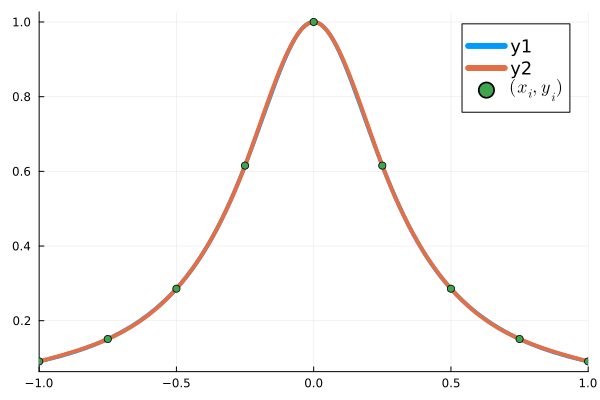

In [4]:
using Interpolations

x = LinRange(-1, 1, 9)
y = runge.(x)
flin = LinearInterpolation(x, y)
fspline = CubicSplineInterpolation(x, y)
# plot([runge, t -> flin(t)], xlims=(-1, 1))
plot([runge, t -> fspline(t)], xlims=(-1, 1))
scatter!(x, y, label = L"(x_i,y_i)")

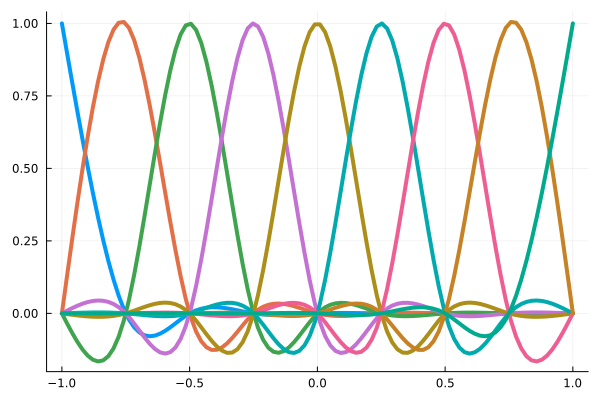

In [5]:
function interp_spline(x, s)
    m, n = length(s), length(x)
    A = diagm(m, n, ones(n))
    for j in 1:n
        fspline = CubicSplineInterpolation(x, A[1:n,j])
        A[:,j] = fspline.(s)
    end
    A
end

s = LinRange(-1, 1, 100)
A = interp_spline(x, s) # here A is 100×9
plot(s, A, legend=:none)

## 1. Spline conditioning

In [6]:
function my_spy(A)
    cmax = norm(vec(A), Inf)
    s = max(1, ceil(120 / size(A, 1)))
    spy(A, marker=(:square, s), c=:diverging_rainbow_bgymr_45_85_c67_n256, clims=(-cmax, cmax))
end

A = interp_spline(LinRange(-1, 1, 40), s) # here A is 100×40
cond(A)

1.5075717485062636

This function uses `spy` (similar to Matlab's `spy` function) to visualize a matrix sparsity pattern. We use a spy plot to see the locations of nonzeros and the values given by the color map.

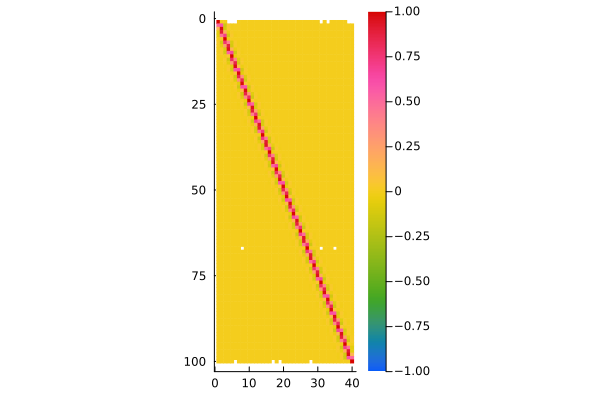

In [7]:
my_spy(A)

### Splines accuracy

In [8]:
function interp_chebyshev(x, xx)
    vander_chebyshev(xx, length(x)) * inv(vander_chebyshev(x))
end

function interp_monomial(x, xx)
    vander(xx, length(x)) * inv(vander(x))
end

function interp_error(ieval, x, xx, test)
    """Compute norm of interpolation error for function test
    using method interp_and_eval from points x to points xx.
    """
    A = ieval(x, xx)
    y = test.(x)
    yy = test.(xx)
    norm(A * y - yy, Inf)
end

function plot_convergence(ievals, ptspaces; xscale=:log10, yscale=:log10, maxpts=40)
    """Plot convergence rates for an interpolation scheme applied
    to a set of tests.
    """
    xx = LinRange(-1, 1, 100)
    ns = 2:maxpts
    fig = plot(title="Convergence",
        xlabel="Number of points",
        ylabel="Interpolation error",
        xscale=xscale,
        yscale=yscale,
        legend=:bottomleft,
        size=(1200, 800))
    for ieval in ievals
        for ptspace in ptspaces
            for test in [runge]
                try
                    errors = [interp_error(ieval, ptspace(-1, 1, n), xx, test)
                             for n in ns]
                    plot!(ns, errors, marker=:circle, label="$ieval/$ptspace")
                catch
                    continue
                end
            end
        end
    end
    for k in [1, 2, 3]
        plot!(ns, ns .^ (-1.0*k), color=:black, label="\$n^{-$k}\$")
    end
    fig
end


plot_convergence (generic function with 1 method)

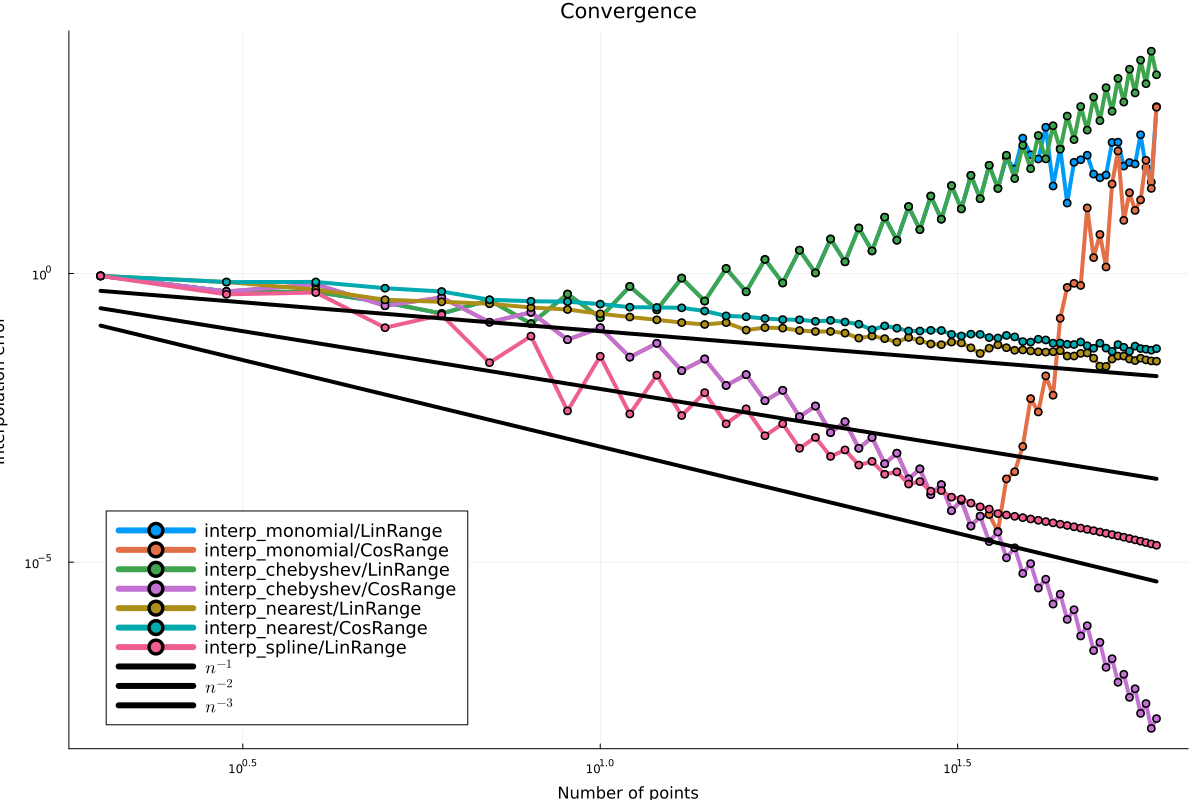

In [9]:
plot_convergence([interp_monomial, interp_chebyshev, interp_nearest, interp_spline], [LinRange, CosRange], maxpts=60)

Note that this convergence plot is specifically for the Runge function example given above, i.e., $f(x) = \frac{1}{1+x^2}$. In general, convergence rates depend on smoothness of $f$.

In general, a smoother f $\Rightarrow$ faster convergence.

## 2. Boundary Value Problems

How can generalize all this?

We saw that to create a Vandermonde matrix, we choose a family of functions $\phi_j(x)$ and a set of points $x_i$, then create the matrix
$$ V_{ij} = \phi_j(x_i) .$$

### What if we wanted to approximate integrals of functions?

$$ B_{ij} = \int_{(x_{i-1} + x_i)/2}^{(x_i + x_{i+1})/2} \phi_j(s) ds$$

This leads to conservative reconstruction, which is an important part of finite volume methods, which are industry standard for shock dynamics.


### What if we wanted to approximate derivatives of functions?


What if we instead computed derivatives?

$$ A_{ij} = \phi_j'(x_i) $$

If we have the canonical, monomial basis, say up to third degree:

$$\Bigg[ 1 \Bigg|\, x \Bigg|\, x^2 \,\Bigg|\, x^3 \Bigg] $$

Then the derivative looks like:

$$
\Bigg[ 0 \Bigg|\, 1 \Bigg|\, 2x \,\Bigg|\, 3x^2 \Bigg] $$

In [10]:
function diff_monomial(x)
    n = length(x)
    A = zeros(n, n)
    A[:,2] = one.(x)
    for j in 3:n
        A[:,j] = A[:,j-1] .* x * (j - 1) / (j - 2)
    end
    A
end

diff_monomial(LinRange(-1, 1, 4))

4×4 Matrix{Float64}:
 0.0  1.0  -2.0       3.0
 0.0  1.0  -0.666667  0.333333
 0.0  1.0   0.666667  0.333333
 0.0  1.0   2.0       3.0

### A stable basis: Chebyshev polynomials

Recall that Chebyshev polynomials satisfy a convenient recurrence:
$$\begin{split}
T_0(x) &= 1 \\
T_1(x) &= x \\
T_{n+1}(x) &= 2 x T_n(x) - T_{n-1}(x)
\end{split}$$

Derivatives of Chebyshev polynomials also satisfy a recurrence.


In [11]:
function chebdiff(x, n=nothing)
    T = vander_chebyshev(x, n)
    m, n = size(T)
    dT = zero(T)
    dT[:,2:3] = [one.(x) 4*x]
    for j in 3:n-1
        dT[:,j+1] = j * (2 * T[:,j] + dT[:,j-1] / (j-2))
    end
    ddT = zero(T)
    ddT[:,3] .= 4
    for j in 3:n-1
        ddT[:,j+1] = j * (2 * dT[:,j] + ddT[:,j-1] / (j-2))
    end
    T, dT, ddT
end

chebdiff (generic function with 2 methods)

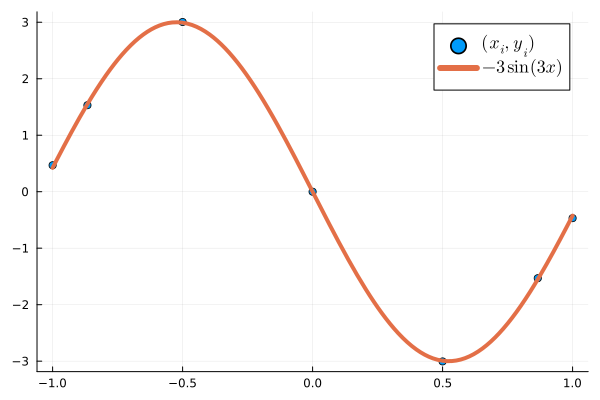

In [12]:
x = CosRange(-1, 1, 7)
T, dT, ddT = chebdiff(x)
c = T \ cos.(3x)
scatter(x, dT * c, label =L"(x_i,y_i)")
plot!(s -> -3sin(3s), label =L"-3\sin(3x)")

### Solving a BVP with Chebyshev collocation

In our Midterm Project, we already saw a boundary value problem (BVP). We asked ourselves to find a function $u(x)$ satisfying an equation like:

$$ -u_{xx}(x) = f(x) $$
subject to **Boundary Conditions**. This time, let's use the following boundary conditions:
 $$u(-1) = a \quad \textrm{ and } \quad u'(1) = b$$

The above Boundary Conditions are mixed: at the left endpoint of the interval, we have the Dirichelet Boundary Condition (which imposes a condition on the function $u$ itself). At the right endpoint of the interval, we have a Neumann Boundary Condition (which imposes a condition on the first derivative of the function).

We'll use the "**method of manufactured solutions**": 

Choose $u(x) = \tanh(2x)$ and solve with the corresponding $f(x)$. In practice, $f(x)$ comes from the physics of the problem or observations, and you need to solve for the unknown $u(x)$.

In [13]:
function poisson_cheb(n, rhsfunc, leftbc=(0, zero), rightbc=(0, zero))
    x = CosRange(-1, 1, n)
    T, dT, ddT = chebdiff(x)
    L = -ddT
    rhs = rhsfunc.(x)
    for (index, deriv, func) in
            [(1, leftbc...), (n, rightbc...)]
        L[index,:] = (T, dT)[deriv+1][index,:]
        rhs[index] = func(x[index])
    end
    x, L / T, rhs
end

poisson_cheb (generic function with 3 methods)

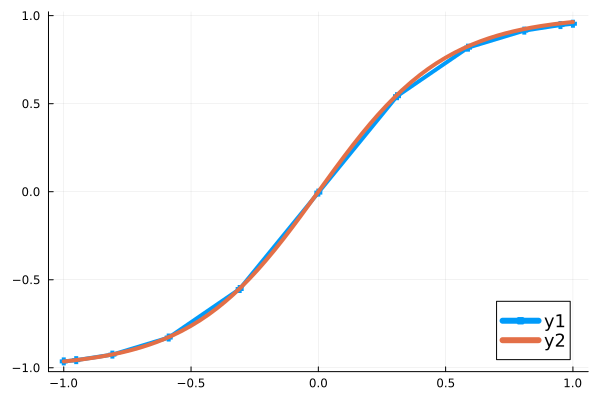

In [14]:
manufactured(x) = tanh(2x)
d_manufactured(x) = 2*cosh(2x)^-2
mdd_manufactured(x) = 8 * tanh(2x) / cosh(2x)^2
x, A, rhs = poisson_cheb(11, mdd_manufactured,
    (0, manufactured), (1, d_manufactured))
plot(x, A \ rhs, marker=:auto)
plot!(manufactured, legend=:bottomright)

### “Spectral” (Exponential) convergence

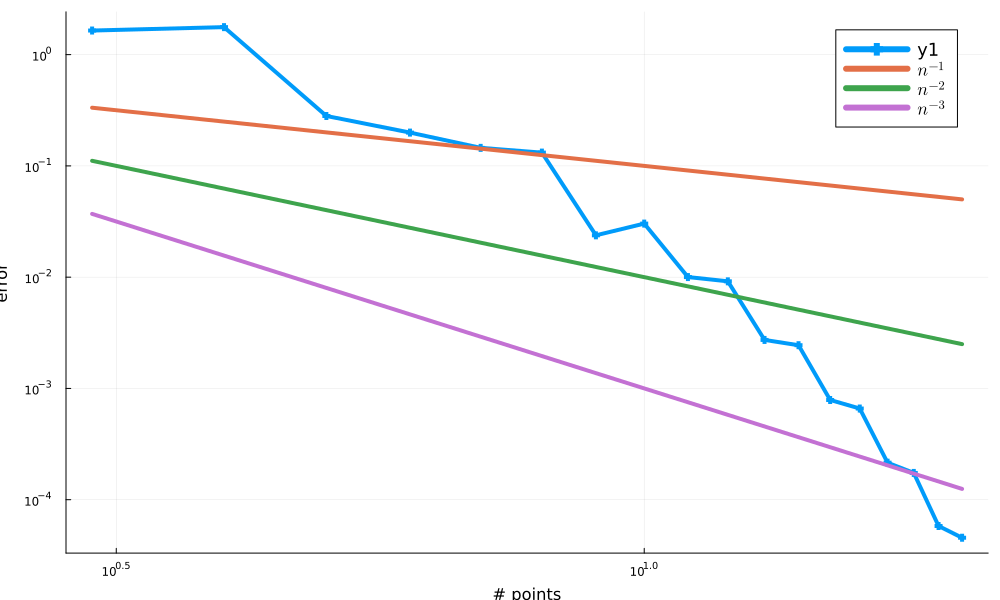

In [19]:
function poisson_error(n)
    x, A, rhs = poisson_cheb(n, mdd_manufactured, (0, manufactured), (1, d_manufactured))
    u = A \ rhs
    norm(u - manufactured.(x), Inf)
end

ns = 3:20
ps = [1 2 3]
plot(ns, abs.(poisson_error.(ns)), marker=:auto, yscale=:log10, xlabel="# points", ylabel="error")
plot!([n -> n^-p for p in ps], label=map(p -> "\$n^{-$p}\$", ps), size=(1000, 600), yscale=:log10, xscale=:log10)

## 3. Higher dimensions: Curse of Dimensionality

Suppose we use a naive Vandermonde matrix to interpolate $n$ data points in an $n$-dimensional space of functions, e.g., predicting $z(x, y)$ from data $(x_i, y_i, z_i)$

$$ \underbrace{\Bigg[ 1 \Bigg| x \Bigg| y \Bigg| xy \Bigg| x^2 \Big| y^2 \Big| x^2 y \Big| xy^2 \Big| x^2y^2 \Big| \dotsb \Bigg]}_{V} \Bigg[ \mathbf c \Bigg] = \Bigg[ \mathbf z \Bigg] $$

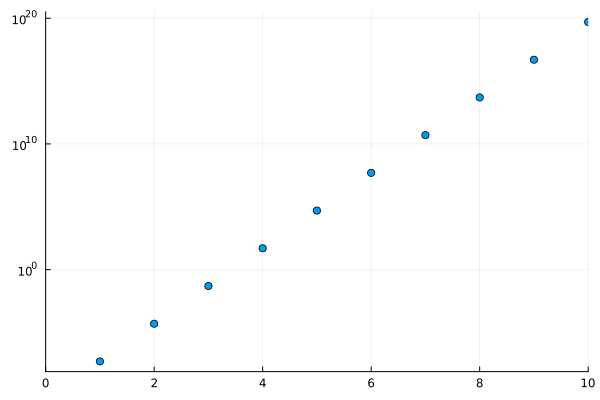

In [20]:
# A grid with 10 data points in each of d dimensions.
points(d) = 10. ^ d
flops(n) = n ^ 3
joules(flops) = flops / 20e9 # 20 GF/joule for best hardware today
scatter(1:10, d -> joules(flops(points(d))), xlims=(0, 10), yscale=:log10, legend=:none)

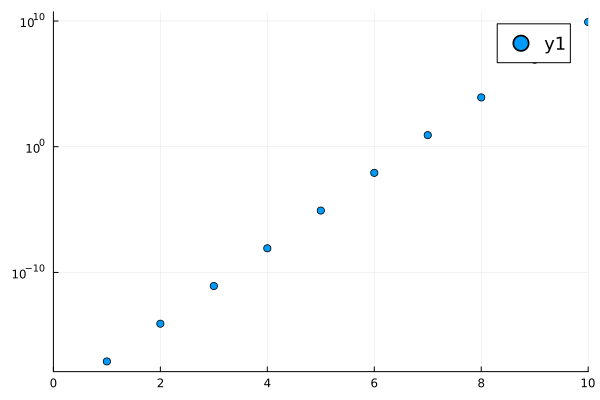

In [21]:
barrels_of_oil(flops) = joules(flops) / 6e9
scatter(1:10, d -> barrels_of_oil(flops(points(d))), xlims=(0, 10), yscale=:log10)

### Fourier series and tensor product structure

For periodic data on the interval $[-\pi, \pi)$, we can use a basis $\{ 1, \sin x, \cos x, \sin 2x, \cos 2x, \dotsc\}$, which is equivalent to $\{ 1, e^{ix}, e^{i2x}, \dotsc \}$ with suitable complex coefficients. 

If we're given equally spaced points on the interval, the Vandermonde matrix $V$ (with suitable scaling) is unitary (like orthogonal for complex matrices) and can be applied in $O(n \log n)$ (with small constants) using the Fast Fourier Transform. This also works for Chebyshev polynomials sampled on `CosRange` points.

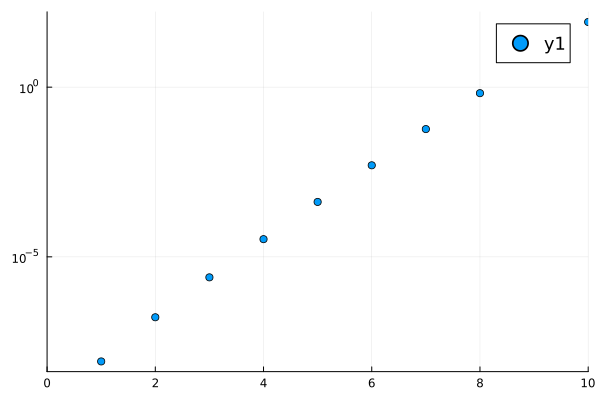

In [22]:
points(d) = 10. ^ d
flops(n) = 5n * log2(n)
joules(flops) = flops / 20e9 # 20 GF/joule for best hardware today
scatter(1:10, d -> joules(flops(points(d))), xlims=(0, 10), yscale=:log10)

### Lower-degree polynomials to fit noise-free data

We can fit $m$ data points using an $n < m$ dimensional space of functions. This involves solving a "least squares problem" for the coefficients

$$ \min_c \lVert V c - y \rVert $$

cond(V) = 30.083506637940346


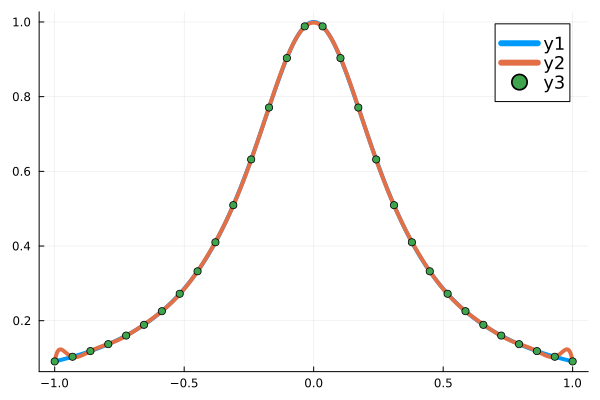

In [23]:
function chebyshev_regress_eval(x, xx, n)
    V = vander_chebyshev(x, n)
    @show cond(V)
    vander_chebyshev(xx, n) / V
end
ndata, nbasis = 30, 20
x = LinRange(-1, 1, ndata)
xx = LinRange(-1, 1, 500)
C = chebyshev_regress_eval(x, xx, nbasis)
plot(xx, [runge.(xx), C * runge.(x)])
scatter!(x, runge)

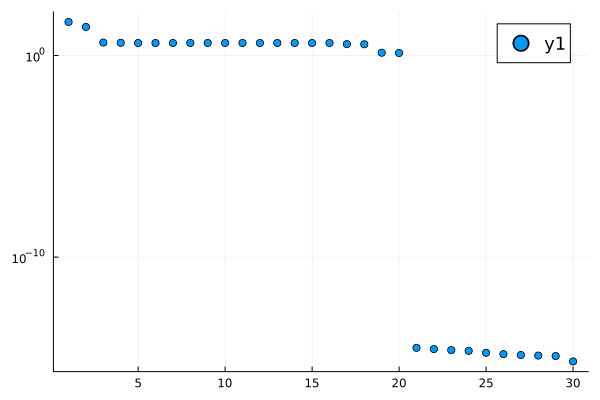

In [24]:
S = svdvals(C)
scatter(S, yscale=:log10)